# [DRAFT] Hierarhical-Gaussian Filter

This notebook does not perform any becnhmark and simply runs the inference procedure and generates some nice plots for the thesis.

Note: This notebook is a draft, the real experiments are in the `notebooks/` folder

_Author: Dmitry Bagaev_

In [6]:
using DrWatson

In [7]:
@quickactivate "RxInferThesisExperiments"

In [140]:
using RxInferThesisExperiments, Turing, StaticArrays, Plots, PGFPlotsX, LaTeXStrings
using LinearAlgebra, StableRNGs, Random, BenchmarkTools, ColorSchemes, Dates, ProgressMeter

In [9]:
# For the thesis I use the `pgfplotsx` backend of the `Plots`, since it generates high-quiality plots
# But it is reallyyy slow, if some wants to generate plots faster uncoment the `gr()` line
# pgfplotsx()

# Use fast plotting backend
gr()

Plots.GRBackend()

In [219]:
# Include the model specification
# include(srcdir("models", "rxinfer", "hgf.jl"));

## Hierarhical Gaussian Filter environment

In [11]:
const environment = HGFEnvironment()

HGFEnvironment()

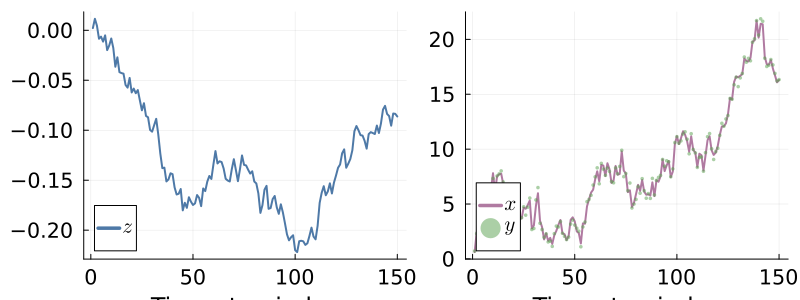

In [271]:
# For plotting purposes I only generate 250 points
T = 150
seed = 12345
rng = StableRNG(seed)

zstates, xstates, observations = rand(rng, environment, T);

# `plotting`range
prange = max((lastindex(observations) - 400), firstindex(observations)):1:lastindex(observations)
colors = ColorSchemes.tableau_10

# Some default settings for plotting
pfontsettings = (
    titlefontsize=18,
    guidefontsize=16,
    tickfontsize=14,
    legendfontsize=14,
    legend = :bottomleft,
    size = (400, 300)
)

p1 = plot(xlabel = "Time step index", ylabel = ""; pfontsettings...)
p1 = plot!(prange, zstates[prange], color = colors[1], linewidth = 2, label = L"z")

p2 = plot(xlabel = "Time step index", ylabel = ""; pfontsettings...)
p2 = plot!(p2, prange, xstates[prange], color = colors[7], linewidth = 2, label = L"x")
p2 = scatter!(p2, prange, observations[prange], color = colors[5], ms = 2, alpha = 0.5, msw = 0, label = L"y")

plot(p1, p2, layout = @layout([ a b ]), size = (800, 300))

HGF (generic function with 4 methods)

In [274]:
using StatsFuns

extract_params_for_next_step (generic function with 6 methods)

In [276]:
using Logging

In [277]:
function execute_inference(method::NUTS, model; rng, nsamples)
    return sample(rng, model, method, nsamples);
end

function execute_inference(method::ADVI, model; rng, nsamples)
    return vi(model, method)
end

function inference(observations, kappa, omega; nsamples = 1000, method = NUTS(), rng = StableRNG(42))
    # Disable turing's logger
    return with_logger(NullLogger()) do
        zt_min_prior = Normal(0.0, sqrt(5.0))
        xt_min_prior = Normal(0.0, sqrt(5.0))
        z_std_prior = Gamma(10000000.0, 0.001)
        y_std_prior = Gamma(100.0, 0.1)

        results = []

        @showprogress for observation in observations
    
            model = HGF(observation, zt_min_prior, xt_min_prior, z_std_prior, y_std_prior, kappa, omega)
            result = execute_inference(method, model; rng = rng, nsamples = nsamples)
            stats = extract_params_for_next_step(rng, model, result)

            zt_min_prior = stats[:zt_min_prior]
            xt_min_prior = stats[:xt_min_prior]
            z_std_prior = stats[:z_std_prior]
            y_std_prior = stats[:y_std_prior]

            push!(results, stats)
        end

        return results
    end
end
     

inference (generic function with 2 methods)

In [289]:
@time results = inference(observations, environment.kappa, environment.omega; method = ADVI(50, 1000), nsamples = 100);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:45


165.024133 seconds (1.27 G allocations: 196.408 GiB, 24.07% gc time)


In [294]:
@time results = inference(observations, environment.kappa, environment.omega; nsamples = 100);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:40


160.124057 seconds (1.15 G allocations: 161.653 GiB, 19.91% gc time, 1.36% compilation time: 95% of which was recompilation)


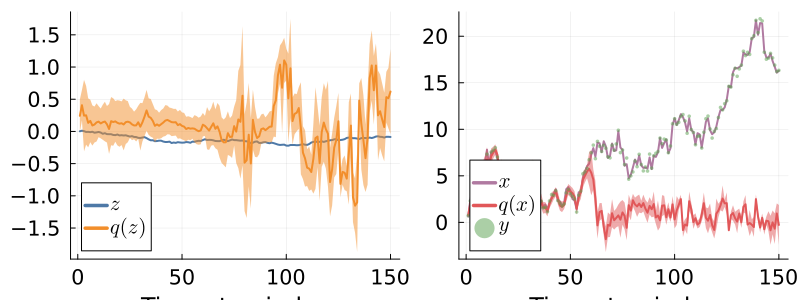

In [295]:
emz = mean.(getindex.(results, :zt_min_prior))
evz = std.(getindex.(results, :zt_min_prior))

emx = mean.(getindex.(results, :xt_min_prior))
evx = std.(getindex.(results, :xt_min_prior))

p1 = plot(xlabel = "Time step index", ylabel = ""; pfontsettings...)
p1 = plot!(p1, prange, zstates[prange], color = colors[1], linewidth = 2, label = L"z")
p1 = plot!(p1, prange, emz[prange], ribbon = evz[prange], color = colors[2], linewidth = 2, label = L"q(z)")

p2 = plot(xlabel = "Time step index", ylabel = ""; pfontsettings...)
p2 = plot!(p2, prange, xstates[prange], color = colors[7], linewidth = 2, label = L"x")
p2 = plot!(p2, prange, emx[prange], ribbon = evx[prange], color = colors[3], linewidth = 2, label = L"q(x)")
p2 = scatter!(p2, prange, observations[prange], color = colors[5], ms = 2, alpha = 0.5, msw = 0, label = L"y")

plot(p1, p2, layout = @layout([ a b ]), size = (800, 300))

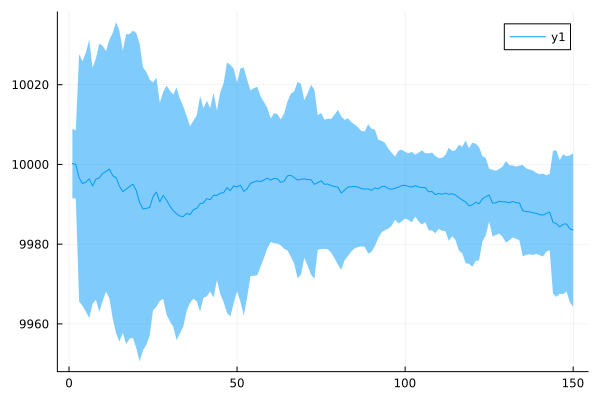

In [296]:
plot(mean.(getindex.(results, :z_std_prior)), ribbon = 3std.(getindex.(results, :z_std_prior)))

In [230]:
using Bijectors

In [238]:
ib = inverse(bijector(Gamma(1.0, 1.0)))

(::Base.Fix1{typeof(broadcast), typeof(exp)}) (generic function with 3 methods)

In [244]:
q = transformed(Normal(-10, 1), ib)

UnivariateTransformed{Normal{Float64}, Base.Fix1{typeof(broadcast), typeof(exp)}}(
dist: Normal{Float64}(μ=-10.0, σ=1.0)
transform: Base.Fix1{typeof(broadcast), typeof(exp)}(broadcast, exp)
)


In [245]:
Distributions.fit(Gamma, rand(q, 10000))

Gamma{Float64}(α=1.1409544415298447, θ=6.61799859261647e-5)